In [1]:
from csv import DictReader

with open('_data/properties_master.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

In [2]:
properties_to_use = [
    'properties.cetane_number.value',
    'properties.ysi_unified.value'
]

samples = []
for row in rows:
    use = True
    for prop in properties_to_use:
        if row[prop] == '-':
            use = False
            break
    if use:
        samples.append(row)

print(len(samples))

150


In [3]:
import numpy as np

data_cn = np.array([float(s['properties.cetane_number.value']) for s in samples]).reshape(-1, 1)

data_ysi = np.array([float(s['properties.ysi_unified.value']) for s in samples]).reshape(-1, 1)

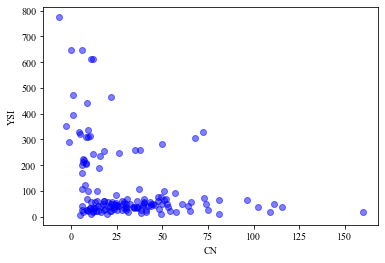

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('CN')
plt.ylabel('YSI')
plt.scatter(data_cn, data_ysi, color='blue', alpha=0.5)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from ecnet.datasets import QSPRDataset

smiles = [s['canonical_smiles'] for s in samples]
smiles_train, smiles_test, cn_train, cn_test, ysi_train, ysi_test = train_test_split(smiles, data_cn, data_ysi, test_size=0.25, random_state=0)

ds_cn_train = QSPRDataset(smiles_train, cn_train, backend='alvadesc')
ds_cn_test = QSPRDataset(smiles_test, cn_test, backend='alvadesc')

ds_ysi_train = QSPRDataset(smiles_train, ysi_train, backend='alvadesc')
ds_ysi_test = QSPRDataset(smiles_test, ysi_test, backend='alvadesc')

In [6]:
from sklearn.decomposition import PCA
import torch

pca_cn = PCA()
pca_ysi = PCA()

pca_cn.fit(ds_cn_train.desc_vals.detach().numpy())
pca_ysi.fit(ds_ysi_train.desc_vals.detach().numpy())

ds_cn_train.desc_vals = torch.tensor(pca_cn.transform(ds_cn_train.desc_vals.detach().numpy())).type(torch.float32)
ds_cn_train.target_vals = ds_cn_train.target_vals.type(torch.float32)
ds_cn_test.desc_vals = torch.tensor(pca_cn.transform(ds_cn_test.desc_vals.detach().numpy())).type(torch.float32)
ds_cn_test.target_vals = ds_cn_test.target_vals.type(torch.float32)

ds_ysi_train.desc_vals = torch.tensor(pca_ysi.transform(ds_ysi_train.desc_vals.detach().numpy())).type(torch.float32)
ds_ysi_train.target_vals = ds_ysi_train.target_vals.type(torch.float32)
ds_ysi_test.desc_vals = torch.tensor(pca_ysi.transform(ds_ysi_test.desc_vals.detach().numpy())).type(torch.float32)
ds_ysi_test.target_vals = ds_ysi_test.target_vals.type(torch.float32)

print(ds_cn_train.desc_vals.shape, ds_cn_test.desc_vals.shape)
print(ds_ysi_train.desc_vals.shape, ds_ysi_test.desc_vals.shape)
print(ds_cn_train.desc_vals.type())

torch.Size([112, 112]) torch.Size([38, 112])
torch.Size([112, 112]) torch.Size([38, 112])
torch.FloatTensor


In [7]:
from ecnet import ECNet

print('Cetane number...')
model_cn = ECNet(ds_cn_train.desc_vals.shape[1], ds_cn_train.target_vals.shape[1], 1024, 1)
train_loss_cn, valid_loss_cn = model_cn.fit(dataset=ds_cn_train, epochs=500, valid_size=0.33, shuffle=True, patience=32, verbose=10, lr=0.001)

print('Yield sooting index...')
model_ysi = ECNet(ds_ysi_train.desc_vals.shape[1], ds_ysi_train.target_vals.shape[1], 1024, 1)
train_loss_ysi, valid_loss_ysi = model_ysi.fit(dataset=ds_ysi_train, epochs=500, valid_size=0.33, shuffle=True, patience=32, verbose=10, lr=0.001)

Cetane number...
Epoch: 0 | Train loss: 4069.17453125 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 3381.603738606771 | Valid loss: 697.3478393554688
Epoch: 20 | Train loss: 292.24329528808596 | Valid loss: 211.78187561035156
Epoch: 30 | Train loss: 226.18806864420574 | Valid loss: 74.68150329589844
Epoch: 40 | Train loss: 121.80044448852539 | Valid loss: 51.589996337890625
Epoch: 50 | Train loss: 84.56910250345867 | Valid loss: 37.71813201904297
Epoch: 60 | Train loss: 57.032198677062986 | Valid loss: 23.946529388427734
Epoch: 70 | Train loss: 32.12268679300944 | Valid loss: 15.456110954284668
Epoch: 80 | Train loss: 20.889398345947267 | Valid loss: 9.07455825805664
Epoch: 90 | Train loss: 131.63869293212892 | Valid loss: 50.69898223876953
Epoch: 100 | Train loss: 63.82416559855143 | Valid loss: 31.185880661010742
Epoch: 110 | Train loss: 27.844875030517578 | Valid loss: 8.505217552185059
Epoch: 120 | Train loss: 4.987980651855469 | Valid loss: 3.6260581016540527
Epoch: 13

In [8]:
from sklearn.metrics import r2_score, median_absolute_error

pred_train_cn = model_cn(ds_cn_train.desc_vals).detach().numpy()
pred_test_cn = model_cn(ds_cn_test.desc_vals).detach().numpy()

pred_train_ysi = model_ysi(ds_ysi_train.desc_vals).detach().numpy()
pred_test_ysi = model_ysi(ds_ysi_test.desc_vals).detach().numpy()

mae_train_cn = median_absolute_error(ds_cn_train.target_vals.detach().numpy(), pred_train_cn)
mae_test_cn = median_absolute_error(ds_cn_test.target_vals.detach().numpy(), pred_test_cn)
r2_train_cn = r2_score(ds_cn_train.target_vals.detach().numpy(), pred_train_cn)
r2_test_cn = r2_score(ds_cn_test.target_vals.detach().numpy(), pred_test_cn)

mae_train_ysi = median_absolute_error(ds_ysi_train.target_vals.detach().numpy(), pred_train_ysi)
mae_test_ysi = median_absolute_error(ds_ysi_test.target_vals.detach().numpy(), pred_test_ysi)
r2_train_ysi = r2_score(ds_ysi_train.target_vals.detach().numpy(), pred_train_ysi)
r2_test_ysi = r2_score(ds_ysi_test.target_vals.detach().numpy(), pred_test_ysi)

print(f'CN train: {r2_train_cn} | {mae_train_cn}')
print(f'CN test: {r2_test_cn} | {mae_test_cn}')
print(f'YSI train: {r2_train_ysi} | {mae_train_ysi}')
print(f'YSI test: {r2_test_ysi} | {mae_test_ysi}')

CN train: 0.9998881965364335 | 0.04967927932739258
CN test: 0.4615887567648592 | 5.001071929931641
YSI train: 0.9993500282180909 | 1.5123357772827148
YSI test: 0.913359737968048 | 6.176633834838867


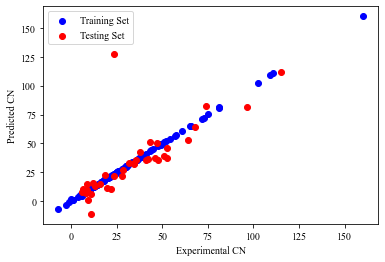

In [9]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.scatter(ds_cn_train.target_vals.detach().numpy(), pred_train_cn, color='blue', label='Training Set')
plt.scatter(ds_cn_test.target_vals.detach().numpy(), pred_test_cn, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

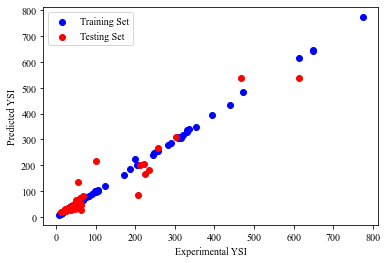

In [10]:
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental YSI')
plt.ylabel('Predicted YSI')
plt.scatter(ds_ysi_train.target_vals.detach().numpy(), pred_train_ysi, color='blue', label='Training Set')
plt.scatter(ds_ysi_test.target_vals.detach().numpy(), pred_test_ysi, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()

In [11]:
data_multiprop = np.append(data_cn, data_ysi, axis=1)
smiles_train, smiles_test, mp_train, mp_test = train_test_split(smiles, data_multiprop, test_size=0.25, random_state=0)
ds_mp_train = QSPRDataset(smiles_train, mp_train, backend='alvadesc')
ds_mp_test = QSPRDataset(smiles_test, mp_test, backend='alvadesc')

pca_mp = PCA()
pca_mp.fit(ds_mp_train.desc_vals.detach().numpy())

ds_mp_train.desc_vals = torch.tensor(pca_mp.transform(ds_mp_train.desc_vals.detach().numpy())).type(torch.float32)
ds_mp_train.target_vals = ds_mp_train.target_vals.type(torch.float32)
ds_mp_test.desc_vals = torch.tensor(pca_mp.transform(ds_mp_test.desc_vals.detach().numpy())).type(torch.float32)
ds_mp_test.target_vals = ds_mp_test.target_vals.type(torch.float32)

In [12]:
model_mp = ECNet(ds_mp_train.desc_vals.shape[1], ds_mp_train.target_vals.shape[1], 1024, 1)
train_loss_mp, valid_loss_mp = model_mp.fit(dataset=ds_mp_train, epochs=500, valid_size=0.33, shuffle=True, patience=32, verbose=10, lr=0.001)

Epoch: 0 | Train loss: 16841.424453125 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 3285.5755403645835 | Valid loss: 2935.97265625
Epoch: 20 | Train loss: 714.0129256184896 | Valid loss: 608.9262084960938
Epoch: 30 | Train loss: 268.1159895833333 | Valid loss: 194.84849548339844
Epoch: 40 | Train loss: 114.1606640625 | Valid loss: 77.55829620361328
Epoch: 50 | Train loss: 69.51402842203775 | Valid loss: 51.74507141113281
Epoch: 60 | Train loss: 58.35225280761719 | Valid loss: 55.723697662353516
Epoch: 70 | Train loss: 60.05789316813151 | Valid loss: 27.13003158569336
Epoch: 80 | Train loss: 46.77968994140625 | Valid loss: 24.203022003173828
Epoch: 90 | Train loss: 16.547424405415853 | Valid loss: 10.312897682189941
Epoch: 100 | Train loss: 222.3138026936849 | Valid loss: 284.9881896972656
Epoch: 110 | Train loss: 22.006978149414063 | Valid loss: 7.988559246063232
Epoch: 120 | Train loss: 15.412451934814452 | Valid loss: 10.147396087646484
Epoch: 130 | Train loss: 32.194756

In [13]:
pred_mp_train = model_mp(ds_mp_train.desc_vals).detach().numpy()
pred_mp_test = model_mp(ds_mp_test.desc_vals).detach().numpy()
pred_mpcn_train = [p[0] for p in pred_mp_train]
pred_mpysi_train = [p[1] for p in pred_mp_train]
pred_mpcn_test = [p[0] for p in pred_mp_test]
pred_mpysi_test = [p[1] for p in pred_mp_test]

exp_mp_train = ds_mp_train.target_vals.detach().numpy()
exp_mp_test = ds_mp_test.target_vals.detach().numpy()
exp_cn_train = [e[0] for e in exp_mp_train]
exp_ysi_train = [e[1] for e in exp_mp_train]
exp_cn_test = [e[0] for e in exp_mp_test]
exp_ysi_test = [e[1] for e in exp_mp_test]

r2_test_cn = r2_score(exp_cn_test, pred_mpcn_test)
r2_test_ysi = r2_score(exp_ysi_test, pred_mpysi_test)
mae_test_cn = median_absolute_error(exp_cn_test, pred_mpcn_test)
mae_test_ysi = median_absolute_error(exp_ysi_test, pred_mpysi_test)

print(f'CN test: {r2_test_cn} | {mae_test_cn}')
print(f'YSI test: {r2_test_ysi} | {mae_test_ysi}')

CN test: 0.4701549453985533 | 4.914755344390869
YSI test: 0.9288175905931382 | 5.688833236694336


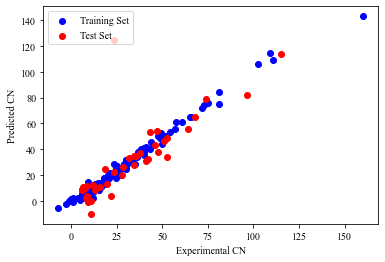

In [14]:
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.scatter(exp_cn_train, pred_mpcn_train, color='blue', label='Training Set')
plt.scatter(exp_cn_test, pred_mpcn_test, color='red', label='Test Set')
plt.legend(loc='upper left')
plt.show()

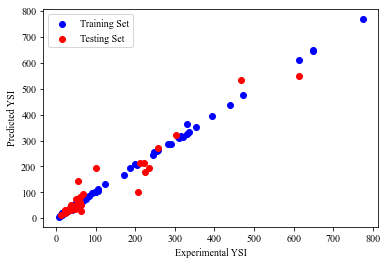

In [15]:
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental YSI')
plt.ylabel('Predicted YSI')
plt.scatter(exp_ysi_train, pred_mpysi_train, color='blue', label='Training Set')
plt.scatter(exp_ysi_test, pred_mpysi_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()